<a href="https://colab.research.google.com/github/A125X/bitcoin-price-prediction/blob/main/btc_lstm_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List
from tqdm.keras import TqdmCallback

In [4]:
df = pd.read_csv("BTC-Hourly.csv", parse_dates=["date"])

In [5]:
df.shape

(33259, 9)

In [6]:
df.head(15)

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USD
0,1646092800,2022-03-01 00:00:00,BTC/USD,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
1,1646089200,2022-02-28 23:00:00,BTC/USD,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06
2,1646085600,2022-02-28 22:00:00,BTC/USD,41657.23,44256.08,41650.29,42907.32,527.540571,2.263535e+07
3,1646082000,2022-02-28 21:00:00,BTC/USD,41917.09,41917.09,41542.60,41659.53,69.751680,2.905822e+06
4,1646078400,2022-02-28 20:00:00,BTC/USD,41361.99,41971.00,41284.11,41914.97,247.151654,1.035935e+07
5,1646074800,2022-02-28 19:00:00,BTC/USD,41228.49,41406.03,41036.37,41362.52,114.268970,4.726453e+06
6,1646071200,2022-02-28 18:00:00,BTC/USD,41432.91,41476.20,41032.06,41233.87,71.233382,2.937228e+06
7,1646067600,2022-02-28 17:00:00,BTC/USD,41031.78,41432.91,40524.73,41432.91,192.789480,7.987829e+06
8,1646064000,2022-02-28 16:00:00,BTC/USD,40860.33,41341.18,40710.00,41008.37,291.623181,1.195899e+07
9,1646060400,2022-02-28 15:00:00,BTC/USD,39830.50,40912.56,39634.59,40846.38,365.055972,1.491121e+07


In [7]:
df["date"].min(), df["date"].max()

(Timestamp('2018-05-15 06:00:00'), Timestamp('2022-03-01 00:00:00'))

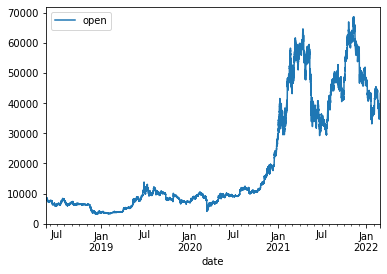

In [8]:
df.plot(x="date", y="open")

In [9]:
df_6_yr = df[df["date"] > df["date"].max() - timedelta(days=365 * 6)]

In [10]:
df_6_yr.shape

(33259, 9)

In [11]:
df_6_yr["date"].min(), df_6_yr["date"].max()

(Timestamp('2018-05-15 06:00:00'), Timestamp('2022-03-01 00:00:00'))

In [15]:
'''
train_size = int(df_6_yr.shape[0] * 0.8)
train_df = df_6_yr.iloc[:train_size]
val_df = df_6_yr.iloc[train_size:]
'''
df = df[::-1]
train_size = int(df.shape[0] * 0.8)
val_df = df.iloc[train_size:]
train_df = df.iloc[:train_size]

In [16]:
train_df.shape, val_df.shape

((26607, 9), (6652, 9))

In [17]:
train_df["date"].min(), train_df["date"].max(), val_df["date"].min(), val_df["date"].max()

(Timestamp('2018-05-15 06:00:00'),
 Timestamp('2021-05-27 20:00:00'),
 Timestamp('2021-05-27 21:00:00'),
 Timestamp('2022-03-01 00:00:00'))

In [25]:
len(train_df)

26607

In [35]:
from keras.preprocessing.sequence import TimeseriesGenerator

generator_train = TimeseriesGenerator(train_df['close'].values, train_df['close'].values, length=14, batch_size=1)
generator_val = TimeseriesGenerator(val_df['close'].values, val_df['close'].values, length=14, batch_size=1)

train_df['close'].values[:5]

array([8740.99, 8739.  , 8728.49, 8708.32, 8795.9 ])

In [37]:
for i in range(5):
    x, y = generator_train[i]
    print('%s => %s' % (x, y))

[[8740.99 8739.   8728.49 8708.32 8795.9  8760.   8760.   8759.23 8517.77
  8520.3  8535.23 8546.34 8526.65 8555.6 ]] => [8512.1]
[[8739.   8728.49 8708.32 8795.9  8760.   8760.   8759.23 8517.77 8520.3
  8535.23 8546.34 8526.65 8555.6  8512.1 ]] => [8492.28]
[[8728.49 8708.32 8795.9  8760.   8760.   8759.23 8517.77 8520.3  8535.23
  8546.34 8526.65 8555.6  8512.1  8492.28]] => [8460.]
[[8708.32 8795.9  8760.   8760.   8759.23 8517.77 8520.3  8535.23 8546.34
  8526.65 8555.6  8512.1  8492.28 8460.  ]] => [8474.99]
[[8795.9  8760.   8760.   8759.23 8517.77 8520.3  8535.23 8546.34 8526.65
  8555.6  8512.1  8492.28 8460.   8474.99]] => [8455.92]


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df[["close"]])
#scaler.fit(train_df[["close"]])

def make_dataset(
    df,
    window_size, 
    batch_size,
    use_scaler=True,
    shuffle=True
    ):
    features = df[["close"]].iloc[:-window_size]
    if use_scaler:
        features = scaler.transform(features)
    data = np.array(features, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=df["close"].iloc[window_size:],
        sequence_length=window_size,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=batch_size)
    return ds

In [ ]:
window_size = 20
batch_size = 900
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(12, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(4, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1)
    ])

lstm_model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )
history = lstm_model.fit(
      train_ds, 
      epochs=10,
      validation_data=val_ds,
      verbose=0, 
      callbacks=[TqdmCallback(verbose=2)]
      )

0epoch [00:00, ?epoch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

  0%|          | 0.00/30.0 [00:00<?, ?batch/s]

In [ ]:
lstm_model.evaluate(train_ds)

30/30 [==============================] - 5s 131ms/step - loss: 925957824.0000 - mean_absolute_error: 23690.3770


[925957824.0, 23690.376953125]

In [ ]:
lstm_model.evaluate(val_ds)

8/8 [==============================] - 1s 53ms/step - loss: 35496820.0000 - mean_absolute_error: 5759.8027


[35496820.0, 5759.802734375]

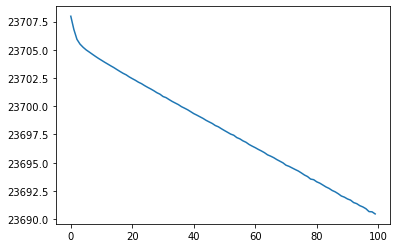

In [ ]:
plt.plot(history.history['mean_absolute_error'])

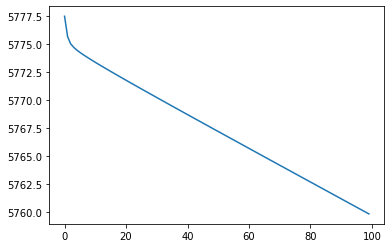

In [ ]:
plt.plot(history.history['val_mean_absolute_error'])

In [ ]:
lstm_model.save('')

In [ ]:
test_ds = make_dataset(
    df=val_df[20:65], 
    window_size=window_size, 
    batch_size=1, 
    use_scaler=True, 
    shuffle=False)

features = val_df[20:65][["close"]].iloc[:]
features = StandardScaler.transform(features)
val_ds = np.array(features, dtype=np.float32)

plt.plot([n for n in range(45)], val_ds[20:65]['close'])

lstm_model.predict(test_ds)

TypeError: ignored

21/21 [==============================] - 0s 6ms/step


array([[17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017],
       [17.86017]], dtype=float32)

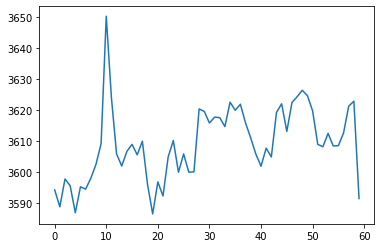

In [ ]:
test_ds = make_dataset(
    df=val_df[120:180], 
    window_size=window_size, 
    batch_size=1, 
    use_scaler=True, 
    shuffle=False)


plt.plot([n for n in range(60)], val_df[120:180]['close'])

lstm_model.predict(test_ds)